# Fourier Neural Operators (FNO) Hands on


### In this tutorial, we will:

- **Introduce the theoretical foundation** of Fourier Neural Operators and their connection to spectral methods.  
- **Implement a classical example** from the original paper by Li et al., where an FNO is trained to solve the 1D Burgers' equation.  
- **Discuss training strategies, architectural choices, and evaluation metrics** to benchmark the model’s performance.  


## Neural Operators

Neural Operators are mappings across discretized function spaces. They serve multiple purposes:

* Mapping from an initial condition to the solution function at a later temporal point (or to the entire spatiotemporal solution function)
* Creating autoregressive timesteppers that transition state $u^{[t]}_h$ to state $u_h^{[t+1]}$

Fourier Neural Operators leverage the Fast Fourier Transform (FFT) to conduct efficient **spectral convolution** while capturing global features. They represent a multiscale architectural approach.

For comprehensive insights into FNO, the original research paper provides detailed explanations.

Neural Operators facilitate solving entire parametric families of Partial Differential Equations.
FNOs notably enable **zero-shot superresolution**.

### Spectral Convolutions

Given the (real-valued) input discretized state $a$ (potentially multi-channeled) defined on an equidistant mesh, follow these steps:

1. Transform $a$ into Fourier space (using real-valued Fourier transform): $\hat{a} = \text{rfft}(a)$ (batch over the channel dimension)
2. Execute a batched matrix multiplication with a complex-valued weight vector $W$ for the initial $K$ modes: $\hat{\tilde{a}}_{0:K} = W\hat{a}_{0:K}$
3. Zero out remaining modes $\hat{\tilde{a}}_{K:} = 0 + 0i$
4. Transform back to real space $\tilde{a} = \text{irfft}(\hat{\tilde{a}})$

Each spectral convolution's learnable parameters comprise a complex-valued weight matrix shaped (channels_out, channels_in, modes), effectively representing 2 * channels_out * channels_in * modes real parameters.

### Fourier Neural Operator

A standard FNO comprises a lifting layer, multiple "ResNet"-style spectral convolution blocks with bypass, and a projection layer. Projection and lifting layers utilize 1x1 Convolutions to modify channel dimensions. The blocks operate via $b = \text{activation}(\tilde{a} + \text{Conv}_{1\times1}(a))$.

We'll replicate an example from the original paper by [Li et al.] solving the **1d Burgers equation**:

$$ \frac{\partial u}{∂ t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

The periodic domain $\Omega = (0, 2 \pi)$ maintains the condition $u(t, x=0) = u(t, x=2 \pi)$ with a fixed diffusivity of $\nu=0.1$. Our dataset includes $2048$ initial conditions $u(t=0, x)$ at $N=8192$ resolution, accompanied by their one-time-step solution $u(t=1, x)$. The FNO aims to learn the mapping from initial condition to one-step state using supervised learning.

### Implementation Details

* Training utilizes a $32$-fold downsampled dataset (i.e., $256$ degrees of freedom instead of $8192$)
    * Training occurs on the first 1000 data points
    * Validation/Testing uses the subsequent 200 data points
* The FNO incorporates $16$ modes, $64$ hidden channels, and four stacked spectral convolution blocks with bypass
* Dataset reshuffling occurs each epoch with a batch size of $100$
* Training spans $200$ epochs
* Adam optimizer with default settings and a fixed learning rate of 3e-4 is employed

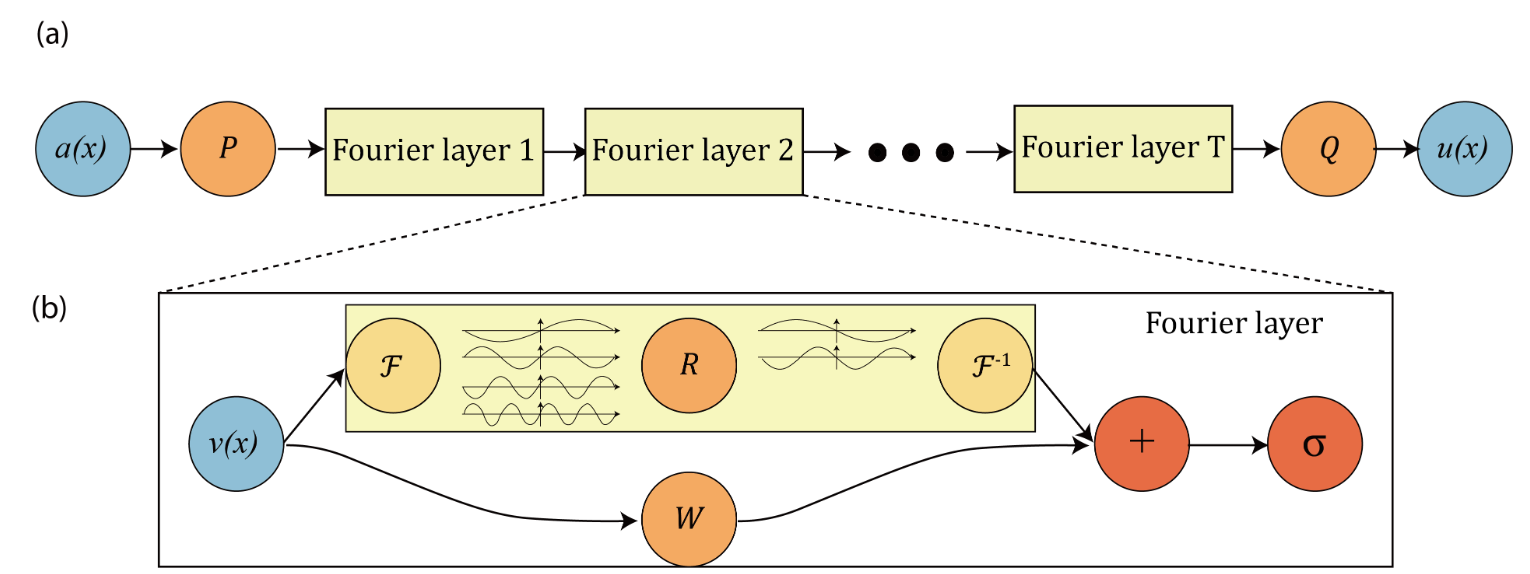

In [1]:
%pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.2 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

<ipython-input-2-8ceb1e6957f4>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Mathworks (the creators of Matlab) host the original Li et al. dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2024-12-15 01:34:10--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 72.246.161.207
Connecting to ssd.mathworks.com (ssd.mathworks.com)|72.246.161.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M   131MB/s    in 5.0s    

2024-12-15 01:34:15 (122 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [4]:
data = scipy.io.loadmat("burgers_data_R10.mat")

In [5]:
a, u = data["a"], data["u"]

In [6]:
a.shape

(2048, 8192)

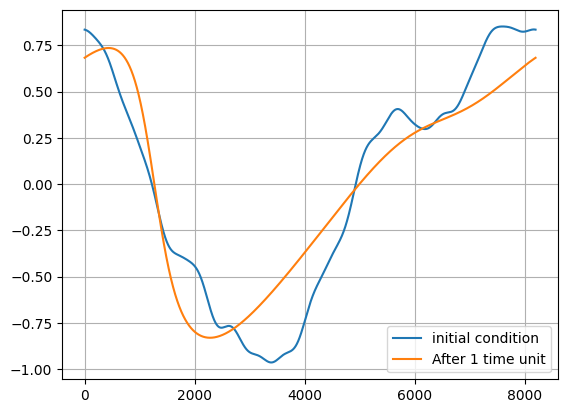

In [7]:
plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [8]:
# Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [9]:
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

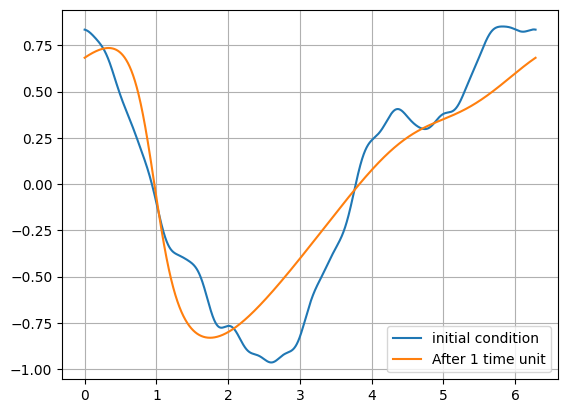

In [10]:
plt.plot(mesh, a[0, 0], label="initial condition")
plt.plot(mesh, u[0, 0], label="After 1 time unit")
plt.legend()
plt.grid()

In [11]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)

In [12]:
a_with_mesh.shape

(2048, 2, 8192)

In [13]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [14]:
class SpectralConv1d(eqx.Module):


    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iM,ioM->oM", x_hat, w)


    def __call__(
            self,
            x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out


In [15]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [16]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))

        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )

    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [17]:
fno = FNO1d(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [18]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [19]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

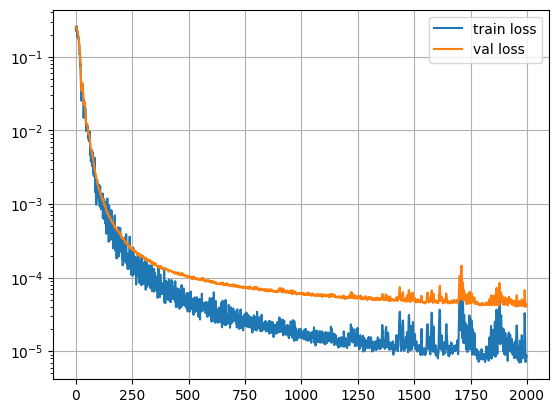

In [20]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

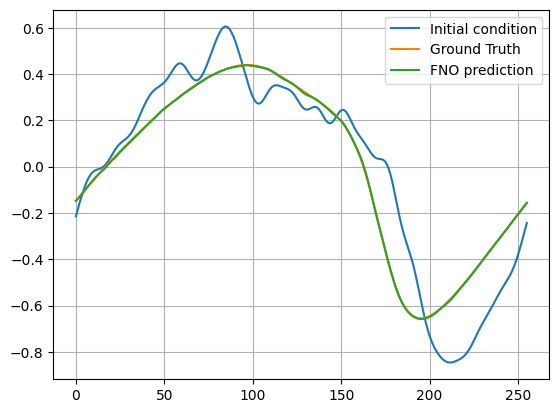

In [21]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
plt.legend()
plt.grid()

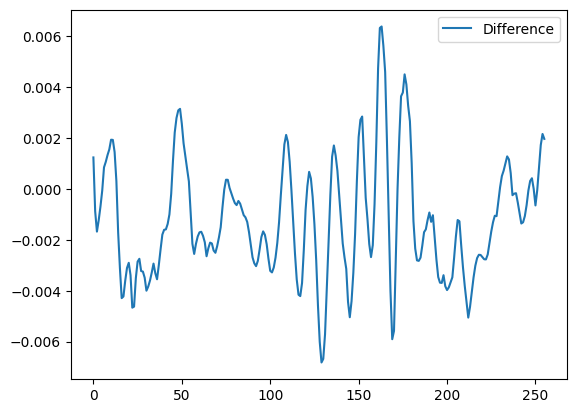

In [22]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()

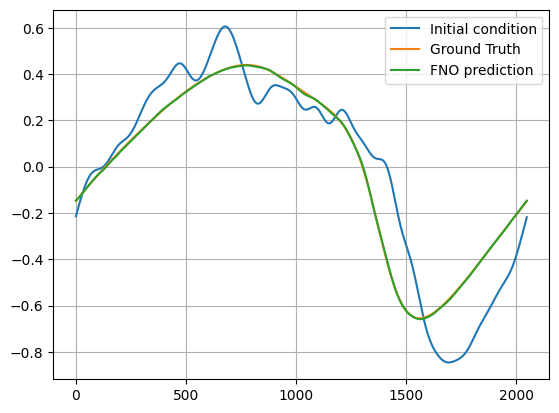

In [23]:
# Zero-Shot superresolution
plt.plot(test_x[1, 0, ::4], label="Initial condition")
plt.plot(test_y[1, 0, ::4], label="Ground Truth")
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
plt.legend()
plt.grid()


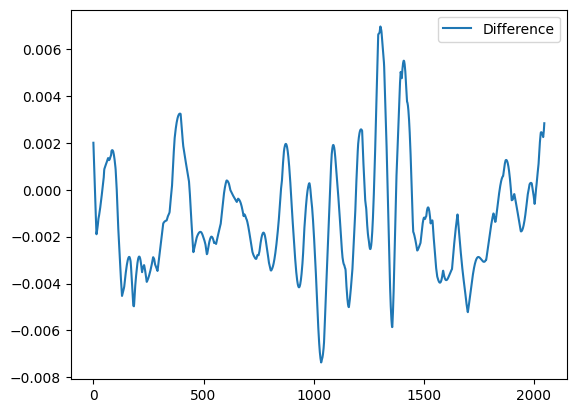

In [24]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()

In [25]:
# Compute the error as reported in the FNO paper
test_pred = jax.vmap(fno)(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [26]:
rel_l2_set.shape

(200,)

In [27]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.00950121, dtype=float32)

##References:

[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895) by Li et al. (2020).
